# Feature Selection/Engineering and Pre-Processing 2

* [Dropping next_14days features](#chapter1)
* [Dropping aircon_sum_wo_prev14d](#chapter2)
* [Correlation on remaining weather features](#chapter3)
* [ge_min_persistance_prev14d has only 0 values](#chapter4)
* [t-testing changes](#chapter5)
* [Correlation alarm related](#chapter6)



In [1]:
import pandas as pd
import seaborn as sns
import os
import sys
import numpy as np

import matplotlib.pyplot as plt
import datetime as dt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import cross_validate


from sklearn.model_selection import StratifiedKFold

from scipy import stats

sys.path.append('..')


We use an helper file called helper.py which contains support functions to process the original dataframe

In [2]:
from helper import data_container

In [3]:
dataset_path = '../dataset/train.csv'
#testset_path = '../dataset/test.csv'

In [4]:
dataset = pd.read_csv(dataset_path)

container = data_container(dataset, drop=True)
df_14 = container.compute_14d_features()

## Dropping next_14days features  <a class="anchor" id="chapter1"></a>
We drop the next_14_days features since they are identical to the prev14days (as we showed in the data exploration notebook), thus they are not informative and highly correlated with the prev14. <br> We decide to keep the prev14 days because our goal is to predict future behavior given past data (typical case of predictive maintenance). It's more meaningful to predict faults given previous "behaviours" than future ones, especially if the future ones are just the prev14 shifted. 

In [5]:
next_col=[col for col in df_14.columns if 'next' in col and not 'aircon' in col]
df_14_drop = df_14.drop(columns=next_col)

## Dropping aircon_sum_wo_prev14d <a class="anchor" id="chapter2"></a>
This variable if shifted forward of 15 days and then binarized, results in the same identical values of the target variable. We're removing it since it's a leakage of the target variable

In [6]:
df_14_drop = df_14_drop.drop(columns=['aircon_sum_wo_prev14d'])

## Correlation on remaining weather features <a class="anchor" id="chapter3"></a>
We check the correlation between the remaining sets of weather features and we drop the highest correlated ones. 

In [7]:
temp_cols = [col for col in df_14_drop.columns if ('temperature_prev' in col or 'temperature_f' in col)]
rain_cols = [col for col in df_14_drop.columns if ('rain_mm_prev' in col or 'rain_mm_f' in col)]
hum_cols = [col for col in df_14_drop.columns if ('humidity_prev' in col or 'humidity_f' in col)]
wind_cols = [col for col in df_14_drop.columns if ('wind_speed_prev' in col or 'wind_speed_f' in col)]
press_cols = [col for col in df_14_drop.columns if ('pressure_prev' in col or 'pressure_f' in col)]

df_temp=df_14_drop[temp_cols];
df_rain=df_14_drop[rain_cols];
df_hum=df_14_drop[hum_cols];
df_wind=df_14_drop[wind_cols];
df_press=df_14_drop[press_cols]

(0.0, 1.0, 0.0, 1.0)

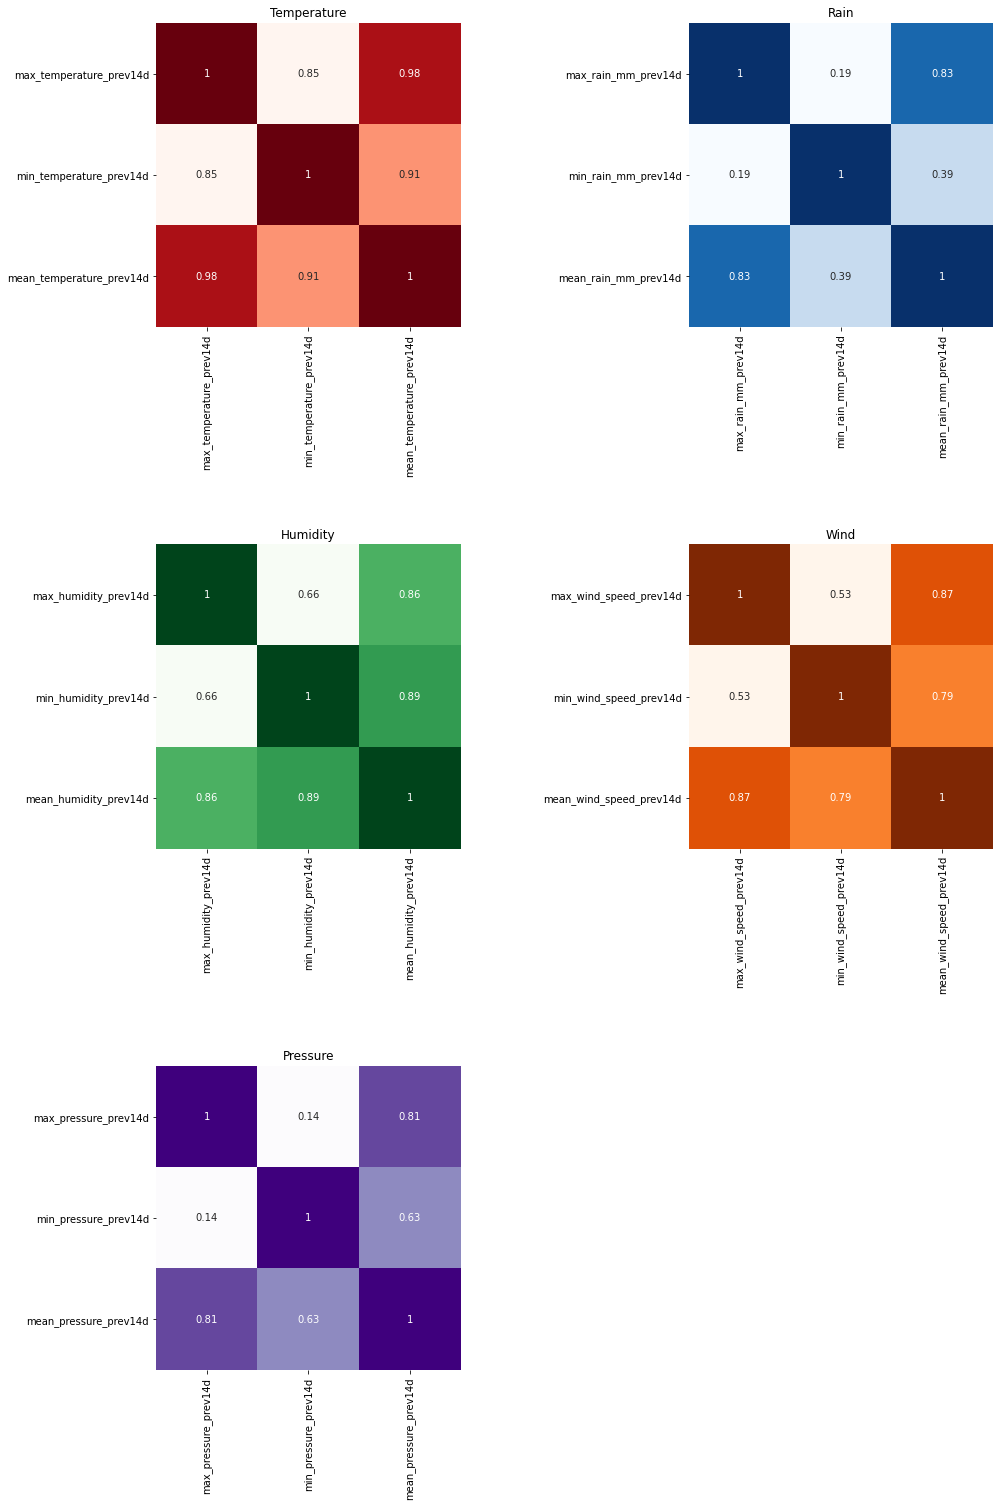

In [8]:
f, axs = plt.subplots(figsize= (15,25), ncols=2, nrows=3)

f.subplots_adjust(wspace=0.75)
f.subplots_adjust(hspace=0.65)

sns.heatmap(df_temp.corr(), square=True, annot=True, ax=axs[0, 0], cmap="Reds", cbar=False).set(title = 'Temperature');
sns.heatmap(df_rain.corr(), square=True, annot=True, ax=axs[0, 1], cmap='Blues', cbar=False).set(title= 'Rain');
sns.heatmap(df_hum.corr(), square=True, annot=True, ax=axs[1, 0], cmap='Greens', cbar=False).set(title= 'Humidity');
sns.heatmap(df_wind.corr(), square=True, annot=True, ax=axs[1, 1], cmap='Oranges', cbar=False).set(title= 'Wind');
sns.heatmap(df_press.corr(), square=True, annot=True, ax=axs[2, 0], cmap='Purples', cbar=False).set(title= 'Pressure');
axs[2, 1].axis('off')

In [9]:
# Create correlation matrix
df_weather = [df_temp, df_rain, df_hum, df_wind, df_press]
drop_columns =[]
for df in df_weather:
    
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
    drop_columns.extend(to_drop)
drop_columns

['mean_temperature_prev14d']

In [10]:
df_14_drop = df_14_drop.drop(columns=drop_columns)

## ge_min_persistance_prev14d has only 0 values <a class="anchor" id="chapter4"></a>
This features has only 0 values, thus we can drop it.

In [11]:
df_14_drop['ge_min_persistance_prev14d'].unique()

array([0.])

In [12]:
df_14_drop = df_14_drop.drop(columns=['ge_min_persistance_prev14d'])

## t-testing changes <a class="anchor" id="chapter5"></a>
We perform a t-test between the original 14 days features dataset we computed in the previous feature selection notebook and the dataset obtained after the selections made in this notebook.

In [13]:
X_14 = df_14.drop(columns=['aircon_sum_target_next14d'])
y_14 = df_14['aircon_sum_target_next14d']

X_14_drop = df_14_drop.drop(columns=['aircon_sum_target_next14d'])
y_14_drop = df_14_drop['aircon_sum_target_next14d']

In [14]:
crossvalidation = StratifiedKFold(n_splits=5, shuffle=True)

In [15]:
scoring = ['precision', 'recall']

In [16]:
clf_RandomForest_14 = RandomForestClassifier(n_estimators = 50, random_state=0)
scores_14 = cross_validate(clf_RandomForest_14, X_14, y_14, scoring=scoring, cv=crossvalidation, verbose = 2, n_jobs= 4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.4min finished


In [17]:
clf_RandomForest_14_drop = RandomForestClassifier(n_estimators = 50, random_state=0)
scores_14_drop = cross_validate(clf_RandomForest_14_drop, X_14_drop, y_14_drop, scoring=scoring, cv=crossvalidation, verbose = 2, n_jobs= 4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  5.0min finished


In [18]:
scores_14

{'fit_time': array([192.05730748, 190.03208041, 188.94170594, 193.09822536,
        122.34770417]),
 'score_time': array([2.78390956, 3.14010119, 3.14210248, 2.42460155, 3.07729983]),
 'test_precision': array([0.87465181, 0.88594164, 0.86388889, 0.88358209, 0.84269663]),
 'test_recall': array([0.43854749, 0.46648045, 0.43375174, 0.41283124, 0.41841004])}

In [19]:
scores_14_drop

{'fit_time': array([177.73766685, 176.56978083, 174.96870852, 177.30591583,
        115.59799576]),
 'score_time': array([4.46981049, 4.45668578, 4.60848498, 4.93353486, 2.40973067]),
 'test_precision': array([0.8968254 , 0.89113924, 0.88601036, 0.90314136, 0.89866667]),
 'test_recall': array([0.47346369, 0.49162011, 0.47698745, 0.48117155, 0.47001395])}

In [20]:
confidence_level = 0.99
paired_test = stats.ttest_rel(scores_14['test_recall'], scores_14_drop['test_recall'])
print(paired_test)

if (paired_test[1]<(1-confidence_level)):
    print('statistically significant')

Ttest_relResult(statistic=-6.056148248224268, pvalue=0.0037521279927599047)
statistically significant


In [21]:
confidence_level = 0.99
paired_test = stats.ttest_rel(scores_14['test_precision'], scores_14_drop['test_precision'])
print(paired_test)

if (paired_test[1]<(1-confidence_level)):
    print('statistically significant')

Ttest_relResult(statistic=-2.9916385161012036, pvalue=0.04027289618294602)


## Correlation alarm related <a class="anchor" id="chapter6"></a>
We check the correlation between the alarm features and we drop the remaining high correlated features.

In [22]:
#ge_min_persistance_prev14d has only zeros, we can remove it
sum_alarms_col = [col for col in df_14_drop.columns if ('sum' in col)]
fire_smoke_cols = [col for col in df_14_drop.columns if ('fire/smoke') in col]
equipment_cols = [col for col in df_14_drop.columns if ('equipment' in col)]
ge_cols = [col for col in df_14_drop.columns if ('ge' in col)]
power_cols = [col for col in df_14_drop.columns if ('power' in col)]
temperature_cols = [col for col in df_14_drop.columns if ('temperature' in col)]

print(ge_cols)
#press_cols = [col for col in df_14.columns if ('pressure_prev' in col or 'pressure_f' in col)]

df_sum=df_14_drop[sum_alarms_col];
df_fire_smoke_cols=df_14_drop[fire_smoke_cols];
df_equipment=df_14_drop[equipment_cols];
df_ge=df_14_drop[ge_cols];
df_power=df_14_drop[power_cols]
df_temperature=df_14_drop[temperature_cols]

['aircon_sum_target_next14d', 'ge_sum_alarms_prev14d', 'skew_ge_alarms_prev14d', 'kurt_ge_alarms_prev14d', 'ge_max_persistance_prev14d', 'ge_mean_persistance_prev14d']


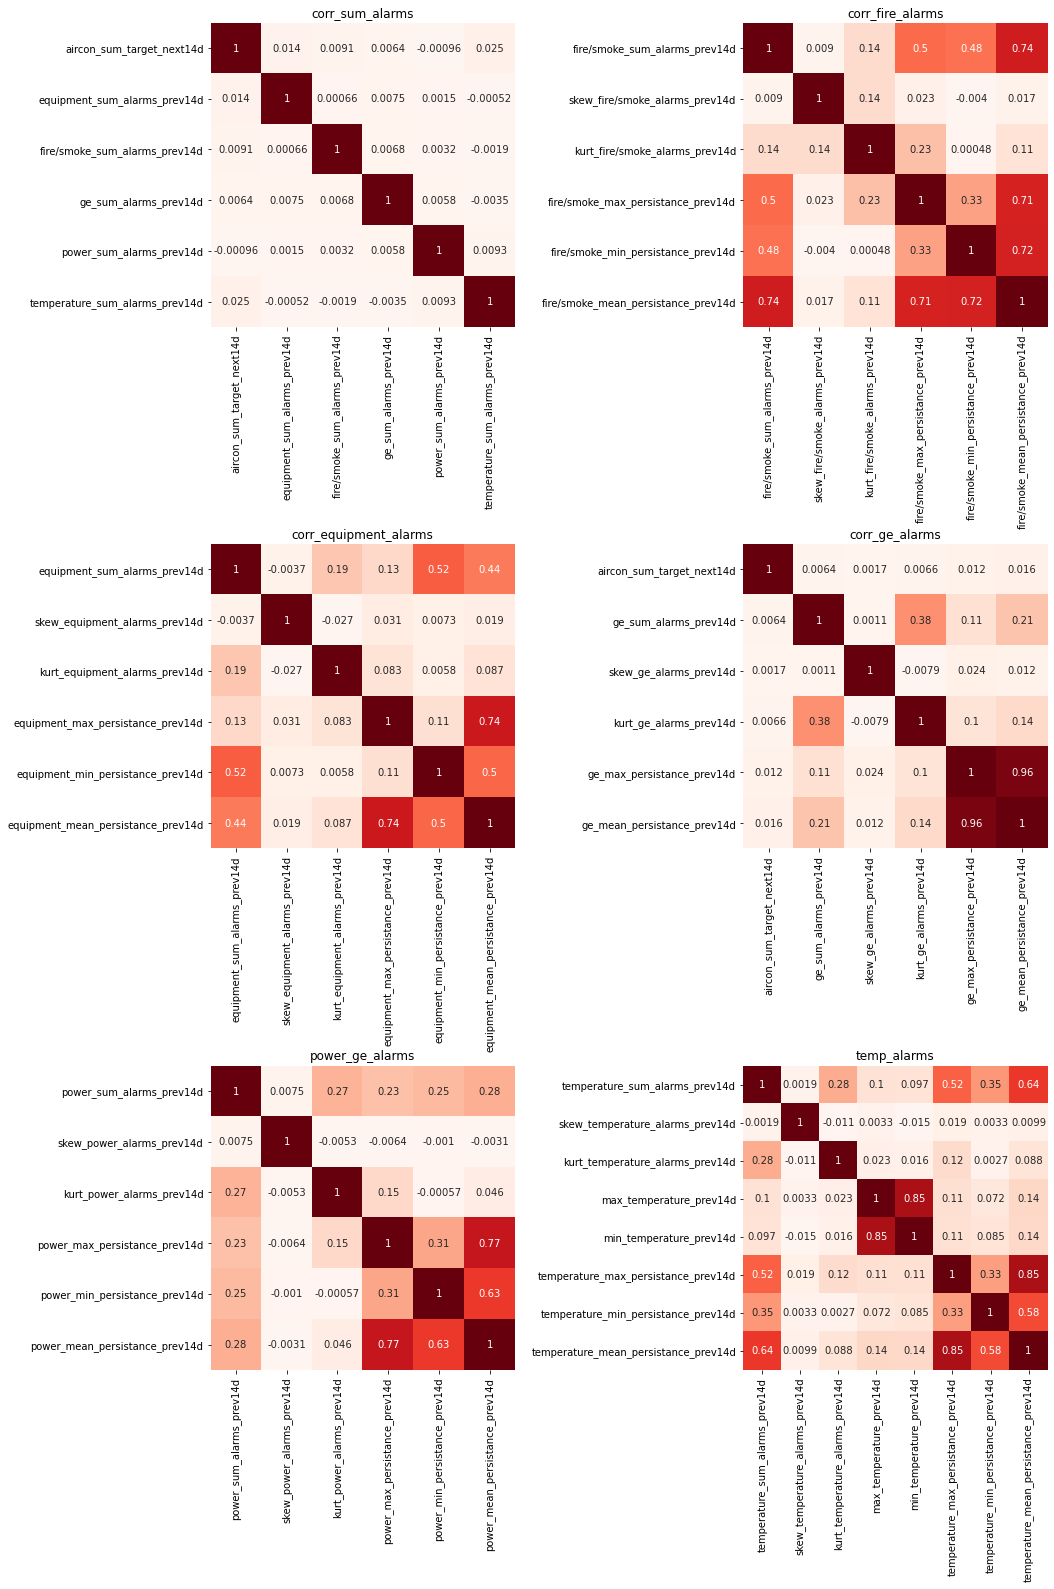

In [23]:
f, axs = plt.subplots(figsize= (15,25), ncols=2, nrows=3)

f.subplots_adjust(wspace=0.75)
f.subplots_adjust(hspace=0.65)

sns.heatmap(df_sum.corr(), square=True, annot=True, ax=axs[0, 0], cmap="Reds", cbar=False).set(title = 'corr_sum_alarms');
sns.heatmap(df_fire_smoke_cols.corr(), square=True, annot=True, ax=axs[0, 1], cmap="Reds", cbar=False).set(title = 'corr_fire_alarms');
sns.heatmap(df_equipment.corr(), square=True, annot=True, ax=axs[1, 0], cmap="Reds", cbar=False).set(title = 'corr_equipment_alarms');
sns.heatmap(df_ge.corr(), square=True, annot=True, ax=axs[1, 1], cmap="Reds", cbar=False).set(title = 'corr_ge_alarms');
sns.heatmap(df_power.corr(), square=True, annot=True, ax=axs[2, 0], cmap="Reds", cbar=False).set(title = 'power_ge_alarms');
sns.heatmap(df_temperature.corr(), square=True, annot=True, ax=axs[2, 1], cmap="Reds", cbar=False).set(title = 'temp_alarms');


In [24]:
# Create correlation matrix
df_weather = [df_sum, df_fire_smoke_cols, df_equipment, df_ge, df_power, df_temperature]
drop_columns =[]
for df in df_weather:
    
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
    drop_columns.extend(to_drop)
    
drop_columns

['ge_mean_persistance_prev14d']

In [25]:
df_14_drop_final = df_14_drop.drop(columns=drop_columns)
df_14_drop_final

,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,...,ge_max_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day_sin,day_cos
0,3.0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,8.978045e-01,-0.440394
1,3.0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,7.907757e-01,-0.612106
2,3.0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,6.513725e-01,-0.758758
3,3.0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4.853020e-01,-0.874347
4,3.0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2.993631e-01,-0.954139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621295,7.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2.012985e-01,0.979530
621296,7.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2.449294e-16,1.000000
621297,7.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.012985e-01,0.979530
621298,7.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3.943559e-01,0.918958
